In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from multiprocessing import Pool
from scipy.constants import c
from scipy.signal import find_peaks
from scipy.stats import norm
plt.style.use("huntstone")
import numpy as np
import sys
sys.path.insert(0, "../../python")
import currents as cp
from plotting import makefig

In [2]:
def I_stats(ind):
    I, ti, p2p = cp.get_current(ind)
    # Get drive and witness currents
    dI = I[np.argmin(abs(ti))]
    dw = I[np.argmin(abs(ti - p2p))]
    ind1 = np.argmin(abs(ti))
    ind2 = np.argmin(abs(ti - 0.02e-12))
    sep = ind2 - ind1
    peaks = find_peaks(I, height = 0.1*dI, distance = 18)[0]
    npeaks = len(peaks)
    return p2p*c*1e6, dI, dw, npeaks

def plot_param(data, name):
    
    fig, ax = makefig()
    n, bins, patches = ax.hist(data, facecolor='blue', alpha=0.75)
    mu = np.mean(data)
    sigma = np.std(data)
    tstring = name + "\n" + r'($\mu$, $\sigma$) = ('\
             + np.str(np.round(mu,2)) + ", " + np.str(np.round(sigma,2)) +')'
    ax.set_title(tstring)
    text = r'$\mu$ = ' + str(np.round(mu,2)) + \
          "\n" + r'$\sigma$ = ' + str(np.round(sigma,2))
    plt.show()

In [3]:
inds  = np.arange(0, 3134, 1)
p = Pool(4)
p2ps, dI, dw, npeaks = zip(*p.map(I_stats, inds))

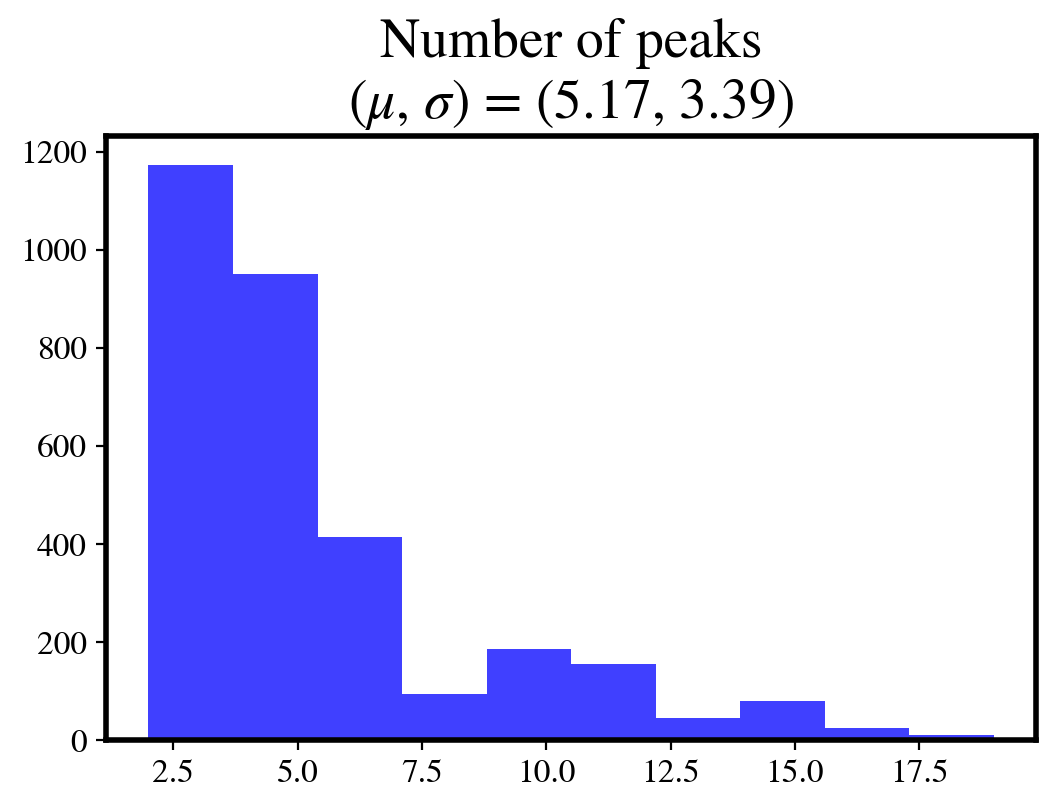

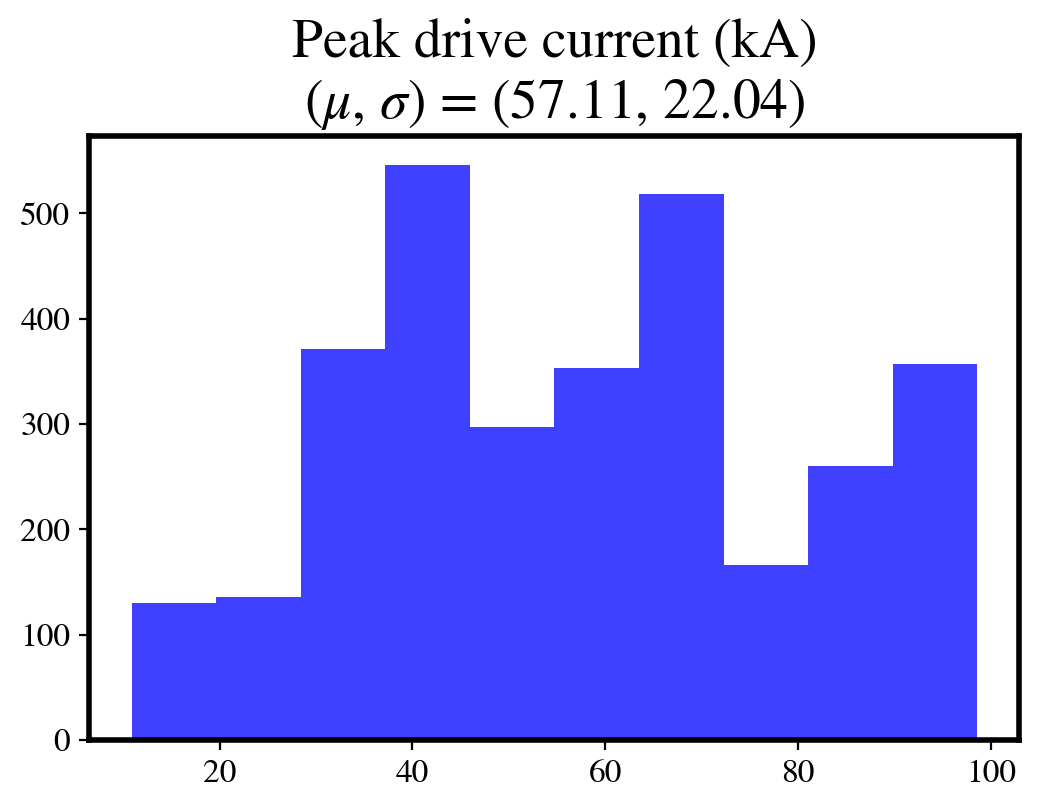

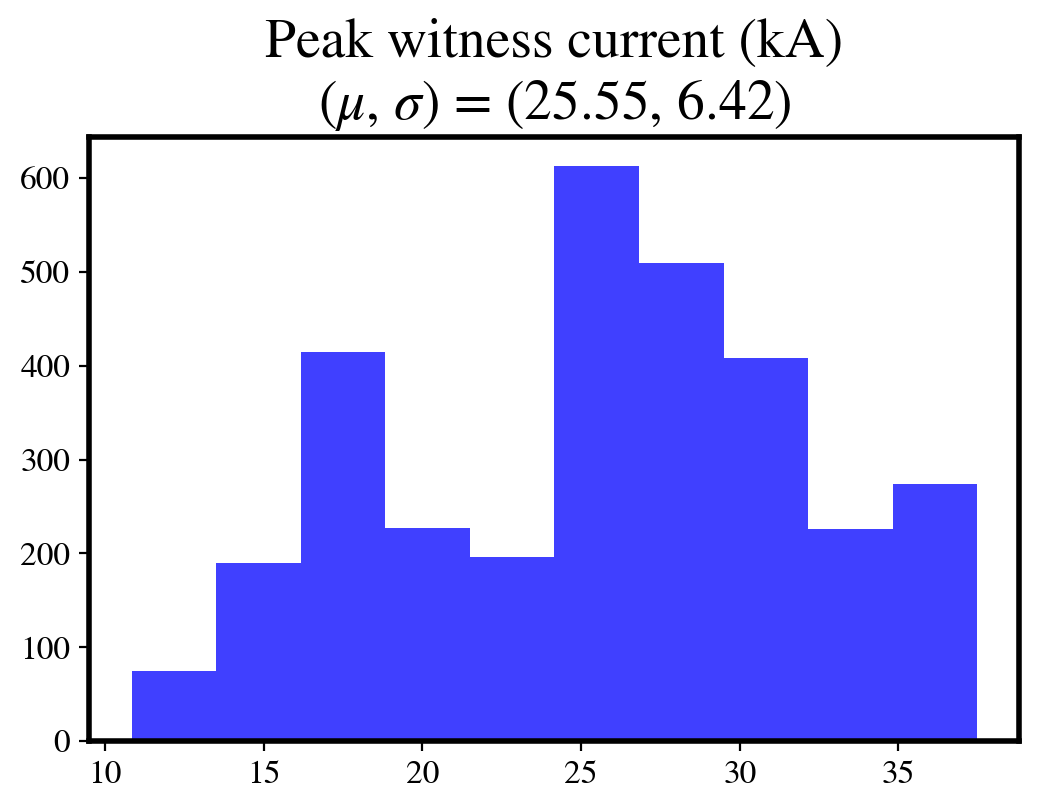

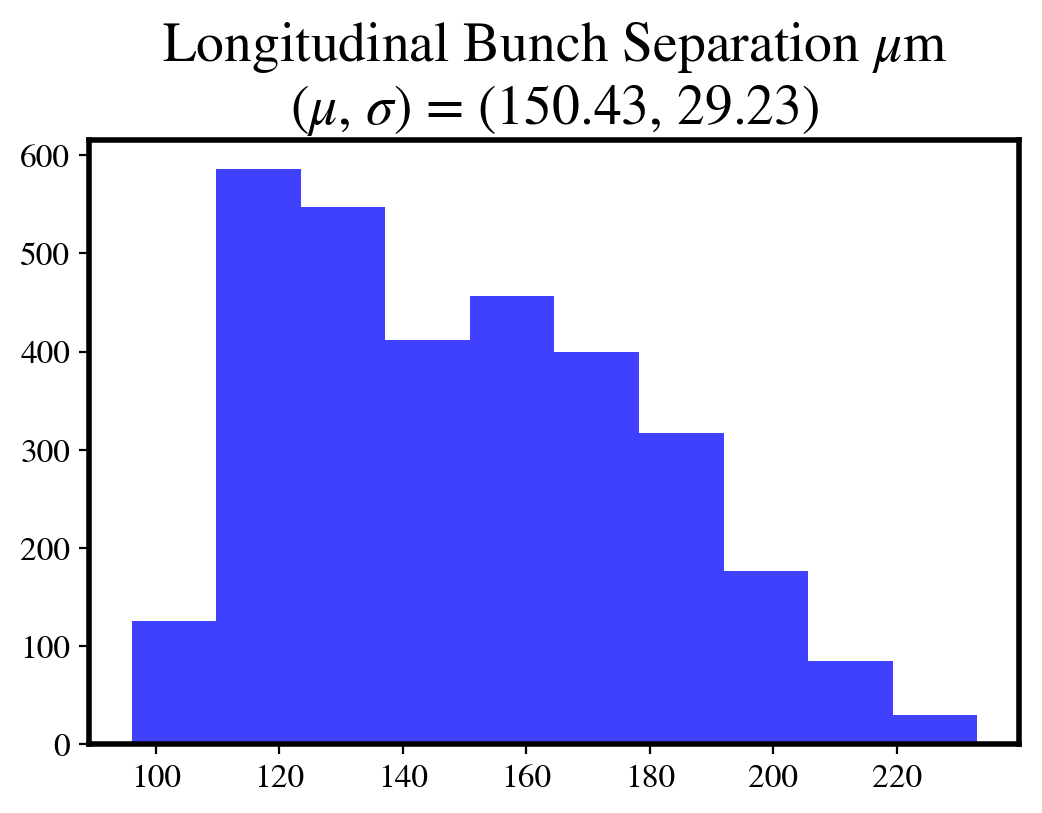

In [4]:
plot_param(npeaks, "Number of peaks")
plot_param(dI, "Peak drive current (kA)")
plot_param(dw, "Peak witness current (kA)")
plot_param(p2ps, r'Longitudinal Bunch Separation $\mu$m')